## 2. Job Salary Prediction

#### importando librerías

In [34]:
import pandas
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.linear_model import LinearRegression
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
import pandas

#### cargando los datos desde el data set Train_rev1.csv

In [35]:
df = pandas.read_csv('Train_rev1.csv')
print "cantidad de datos del dataset: "+str(df.shape)
#sin embargo ya que nuestros computadores no son tan potentes usaremos solo 11000 datos
df = df.iloc[:11000]
df.head(2)

cantidad de datos del dataset: 


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


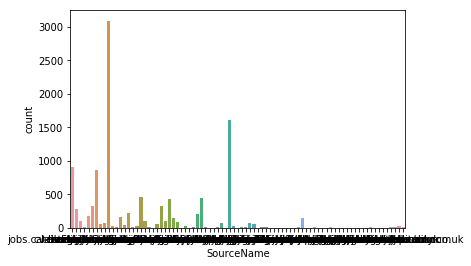

In [36]:
import seaborn as sns
%matplotlib inline
sns.countplot(x= "SourceName",data=df)

In [37]:
#quitamos los datos que no aportan información adicional
#La variable Id no nos entrega ninguna información útil, por lo que no se analizara.
#En el caso del texto bruto de la locación se puede ver que se logra ver la diferencia de los lugares, 
#pero en la locación normalizada se puede apreciar de mejor manera la distribución que tienen los trabajos 
#en diferentes ciudades.
#El salario bruto no esta para nada estandarizado, por lo cual se compara sueldos por año con sueldos por hora, 
#por lo cual no sirve de mucho esta variable, pero por otro lado el salario normalizado se pueden comparar 
#facilmente entre ellos, por lo cual se usara este para comprobar nuestros resultados.
#Por último la fuente tiene su densidad reparitda entre algunas paginas web que son las principales. 
#Esta variable no entrega mucha información, debído a que las páginas simplemente ofrecen trabajos, 
#sin discriminar por sueldo.
df=df.drop(columns=['Id', 'LocationRaw','SalaryRaw','SourceName'])
df.head(2)

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,25000
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,30000


In [38]:
#imprimiendo una breve descripción de los datos de las columnas del dataset que no son textos
print ("df.ContractType")
print (df.ContractType.value_counts())
print ("")
print ("df.ContractTime")
print (df.ContractTime.value_counts())
print ("")
print ("df.LocationNormalized:")
print (df.LocationNormalized.value_counts())
print ("")
print ("df.Company:")
print (df.Company.value_counts())
print ("")
print ("df.Category:")
print (df.Category.value_counts())

df.ContractType
full_time    3279
part_time     602
Name: ContractType, dtype: int64

df.ContractTime
permanent    4683
contract      726
Name: ContractTime, dtype: int64

df.LocationNormalized:
UK                     1429
London                 1022
Manchester              303
Leeds                   251
Belfast                 251
The City                176
Birmingham              147
Surrey                  143
Sheffield               121
South East London       114
Hampshire               114
Bristol                 104
West Midlands            96
Liverpool                84
Berkshire                83
Hertfordshire            81
Cambridge                76
Bradford                 76
Nottingham               75
Newcastle Upon Tyne      74
Cheshire                 72
Lancashire               67
Leicester                64
West Yorkshire           64
Reading                  63
Essex                    61
Oxfordshire              60
Wales                    60
Glasgow              

#### preparando los datos

In [39]:
# reemplazamos todos los valores NaN por un equivalente simbolizado con el string 'nan'
df['FullDescription']=df['FullDescription'].fillna('nan')
df['LocationNormalized']=df['LocationNormalized'].fillna('nan')
df['ContractType']=df['ContractType'].fillna('nan')
df['ContractTime']=df['ContractTime'].fillna('nan')
df['Company']=df['Company'].fillna('nan')
df['Category']=df['Category'].fillna('nan')

#### preparando los datos FullDescription aplicando lower(), quitando puntuación, stopwords, aplicando stemmer, y quitando las palabras raras y las más usadas.

In [40]:
#función remove stopWords
cachedStopWords = stopwords.words("english")
def stopWords(text):
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return text

#función apply stemmer
stemmer = SnowballStemmer("english")
def stemmerWords(text):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

#función lemmetize
lancaster_stemmer = LancasterStemmer()
def lemmatizeWords(text):
    text = ' '.join([lancaster_stemmer.stem(word) for word in text.split()])
    return text


# transformamos los datos con la función lower()
df['FullDescription']=df['FullDescription'].str.lower()

# quitamos todos los carácteres que no son ni letras ni números
df['FullDescription']=df['FullDescription'].replace('[^a-z0-9]', ' ', regex = True)

#quitando stopwords
df['FullDescription'] = df['FullDescription'].apply(lambda x: stopWords(x))

#Stemmer words 
df['FullDescription'] = df['FullDescription'].apply(lambda x: stemmerWords(x))

#removiendo palabras más comunes
freq = list(pandas.Series(' '.join(df['FullDescription']).split()).value_counts()[:100].index)
df['FullDescription'] = df['FullDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


#removiendo palabras raras
freq = list(pandas.Series(' '.join(df['FullDescription']).split()).value_counts()[-120:].index)
df['FullDescription'] = df['FullDescription'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


In [41]:
#mostrando el resultado de la preparación de FullDescription
df.FullDescription.head(2)

0    analyst dork surrey k locat dork surrey analys...
1    stress glasgow talent grow glasgow varieti sui...
Name: FullDescription, dtype: object

#### representando los datos disponibles

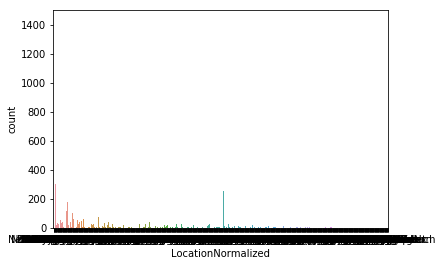

In [42]:

%matplotlib inline
sns.countplot(x= "LocationNormalized",data=df)

#La compañia es una variable que tiene bastante variedad, 
#pero se puede ver que algunas empresas sobresalen con su cantidad de ofertas laborales, 
#esto se puede reforsar con el gráfico.

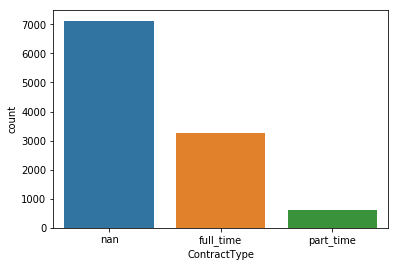

In [43]:
import seaborn as sns
%matplotlib inline
sns.countplot(x= "ContractType",data=df)


#En el caso de del tipo de contrato, podemos ver que solo un pequeño porcentaje tiene alguna categoría asignada. 
#En orden de proporción las estradas que mas abundan son categorías no asignadas.

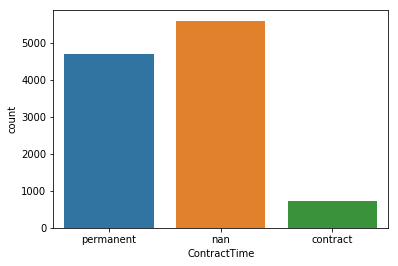

In [44]:
import seaborn as sns
%matplotlib inline
sns.countplot(x= "ContractTime",data=df)

#Para la variable tiempo de contrato sucede algo parecido a la variable anterior

In [45]:
# import seaborn as sns
# %matplotlib inline
# sns.countplot(x= u"Company",data=df)

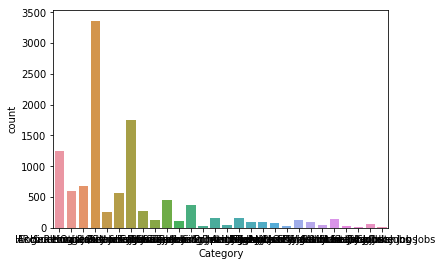

In [46]:
import seaborn as sns
%matplotlib inline
sns.countplot(x= "Category",data=df)
#se aprecian claramente 28 categorías de trabajos bien definidas y distintas en proporción entre si

#### dividiendo los datos de entrenamiento y prueba

In [47]:
import numpy as np
msk = np.random.rand(len(df)) < 0.95
train = df[msk]
val = df[~msk]


#### creamos las matrices de features de FullDescription usando CountVectorizer

In [48]:
# vectorizer = CountVectorizer()
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=2,binary='False')
vectorizer.fit(train['FullDescription'])
#obtenemos las matrices de features utilizando la función vector anterior
X_tfidf = vectorizer.transform(train['FullDescription'])
X_vfidf = vectorizer.transform(val['FullDescription']) 


#### creamos las matrices de features de LocationNormalized y ContractTime a partir de un vector definido con los datos de entrenamiento

In [49]:
enc = DictVectorizer()
enc.fit(train[['Category']].to_dict('records'))
X_train_categ = enc.transform(train[['Category']].to_dict('records'))
X_val_categ = enc.transform(val[['Category']].to_dict('records'))
# [***]
#Los vectores obtenidos no fueron usados pues no fué posible mejorar el modelo con ellos.


#### definimos los inputs X de entrenamiento e Y de validación usando las matrices de features (FullDescription) y (LocationNormalized + ContractTime)

In [50]:
y = train['SalaryNormalized']
yval = val['SalaryNormalized']

X = hstack([X_tfidf])
Xval = hstack([X_vfidf])


# [***]
#Los vectores obtenidos no fueron usados pues no fué posible mejorar el modelo con ellos.
# X = hstack([X_tfidf,X_train_categ])
# Xval = hstack([X_vfidf,X_val_categ])

#### Definiendo y entrenando el modelo

In [51]:
# Modelo de regresión lineal: 
model = LinearRegression(fit_intercept=True, normalize=False)
#fit_intercept = False establece el intercepto y en 0. Si fit_intercept = Verdadero, 
#el intercepto y será determinado por la línea de mejor ajuste.

# Entrenamos el modelo 
model.fit(X, y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Probando los resultados

In [52]:
from sklearn.metrics import mean_absolute_error #measure MAE
print("MAE on train: ",mean_absolute_error(y, model.predict(X)))
print("MAE on val: ",mean_absolute_error(yval, model.predict(Xval)))

('MAE on train: ', 49.10992722859457)
('MAE on val: ', 7471.15625816551)


comentarios:
    Una forma de mejorar el modelo fue cambiando los valores del CountVectorizer usado en FullDescription
    
    CountVectorizer():
        ('MAE on train: ', 79.38692730571627)
        ('MAE on val: ', 67814.20121468042)
    
    CountVectorizer(ngram_range=(1, 2),min_df=2,binary='False'):
        ('MAE on train: ', 44.450243016694564)
        ('MAE on val: ', 8033.962197466592)


La idea es buscar patrones significativos del tipo:
    ngram_range=(1, 2):
        palabra
        palabra1 palabra2
    min_df=2:
        solo palabras o combinaciones de dos palabras que se repitan dos o más veces en los textos
el uso del arte negro anterior mejora el modelo de forma considerable.
PD: seguimos lejos de la versión ganadora MAE 3400.
No se pudo mejorar el modelo agregando combinaciones de variables que previsiblemente mejorarían los resultados
por lo que se optó solo con mejorar la calidad del preprocesamiento de los datos FullDescription
